In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
from math import sqrt
from scipy.signal import argrelextrema
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 10000)
pd.set_option('display.width', 10000)

In [2]:
def read_csv(directory_name , fileName):
    '''
    Read the file from a directory given directory name and file name, we collected all the data in one directory 
    '''
    read_file = 'sensor data/' + directory_name + '/' + fileName + '.csv'
    df = pd.read_csv(read_file)                                 # Create a DataFrame for return value 
    del df['Unnamed: 7']                                        # delete unknown columns to make DataFrame clean  
    df = df[ (df['time'] >= 3) & (df['time'] <= 6) ]            # Only included time from 5s to 15s
    df['aT'] = np.sqrt(df['ax']**2 + df['ay']**2 + df['az']**2) # get total acceleration
    return df                                                   # return the DataFrame

In [3]:
#read_csv('sensor data' , '上楼梯口袋1')

In [4]:
def Butterworth_filter(data):
    b, a = signal.butter(3, 0.05, btype='lowpass', analog=False)
    low_passed = signal.filtfilt(b, a, data)
    return low_passed


def Butterworth_filter_forplot(df):
    df['ax'] = Butterworth_filter(df['ax'])
    df['ay'] = Butterworth_filter(df['ay'])
    df['az'] = Butterworth_filter(df['az'])
    df['wx'] = Butterworth_filter(df['wx'])
    df['wy'] = Butterworth_filter(df['wy'])
    df['wz'] = Butterworth_filter(df['wz'])
    df['aT'] = Butterworth_filter(df['aT'])
    return df


In [5]:
# citation: https://github.com/philip-L/CMPT353-1/blob/master/analysis2.py
# Figure out what happening here, write our own FFT function and report must mention why we do this 
def Butterworth_filter_and_FFT(data):
    # Using the Butterworth filter
    data_bw = data.apply(Butterworth_filter , axis = 0)
    
    del data_bw['time']
    # FFT of the data after the Butterworth filter
    data_FT = data_bw.apply(np.fft.fft , axis = 0)      
    data_FT = data_FT.apply(np.fft.fftshift , axis = 0)
    data_FT = data_FT.abs()
    
    Fs = round(len(data)/data.at[len(data)-1, 'time']) #samples per second
    data_FT['freq'] = np.linspace(-Fs/2, Fs/2, num=len(data))
    return data_FT

In [6]:
#Butterworth_filter_and_FFT(read_csv('sensor data' , '上楼梯口袋1'))

In [7]:
def plot_acceleration_FFT(data_FT):
    plt.figure(figsize = (20, 15))
    plt.plot(data_FT['ax'] , 'r.' , alpha = 0.5)
    plt.title("FFT for total acceleration")

In [8]:
#Butterworth_filter_and_FFT(read_csv('sensor data' , '上楼梯口袋1'))
#plot_acceleration_FFT(Butterworth_filter_and_FFT(read_csv('sensor data' , '走路口袋1')))

In [9]:
def plot_acceleration(data):
    '''
    General function for plot the accleration. Subplot 4 graph, x axis y axis z axis and total accleration
    '''
    plt.figure(figsize = (30, 30))
    plt.subplot(4 , 1 , 1)
    plt.plot(data['time'] , data['ax'] , 'r.' , alpha = 0.5)
    plt.title('X axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 2)
    plt.plot(data['time'] , data['ay'] , 'g.' , alpha = 0.5)
    plt.title('Y axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 3)
    plt.plot(data['time'] , data['az'] , 'b.' , alpha = 0.5)
    plt.title('Z axis acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')
    plt.subplot(4 , 1 , 4)
    plt.plot(data['time'] , data['aT'] , 'k.' , alpha = 0.5)
    plt.title('Total acceleration')
    plt.xlabel('Time(s)')
    plt.ylabel('Acceleration(m/s^2)')

In [10]:
# plot_acceleration(Butterworth_filter_forplot(read_csv('falldown_hold' , 'falldown_hold2')))
# plot_acceleration(read_csv('falldown_hold' , 'falldown_hold2'))

In [11]:
#plot_acceleration(Butterworth_filter_forplot(read_csv('sensor data' , '上楼梯手持8')))

In [12]:
def plot_gyroscope(data):
    '''
    General function for plot the Gyroscope. Subplot 3 graph, x axis y axis z axis
    '''
    plt.figure(figsize = (30, 30))
    plt.subplot(3 , 1 , 1)
    plt.plot(data['time'] , data['wx'] , 'r.' , alpha = 0.5)
    plt.title('X axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')
    plt.subplot(3 , 1 , 2)
    plt.plot(data['time'] , data['wy'] , 'g.' , alpha = 0.5)
    plt.title('Y axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')
    plt.subplot(3 , 1 , 3)
    plt.plot(data['time'] , data['wz'] , 'b.' , alpha = 0.5)
    plt.title('Z axis gyroscope')
    plt.xlabel('Time(s)')
    plt.ylabel('Gyroscope(rad/s)')

In [13]:
#plot_gyroscope(Butterworth_filter_forplot(read_csv('sensor data' , '摔倒手持4')))

In [14]:
def get_basic_feature(data):
    '''
    ax , ay , az , wx , wy , wz , aT
    mean        0.379203
    std         2.659466
    min       -11.236750
    25%        -0.963552
    50%         0.422153
    75%         1.849594
    max         9.068970
    '''
    stat_summary = []
    ax_stat_summary = data['ax'].describe()
    for i in range(1 , 8):
        stat_summary.append(ax_stat_summary[i])
    ay_stat_summary = data['ay'].describe()
    for i in range(1 , 8):
        stat_summary.append(ay_stat_summary[i])
    az_stat_summary = data['az'].describe()
    for i in range(1 , 8):
        stat_summary.append(az_stat_summary[i]) 
    wx_stat_summary = data['wx'].describe()
    for i in range(1 , 8):
        stat_summary.append(wx_stat_summary[i]) 
    wy_stat_summary = data['wy'].describe()
    for i in range(1 , 8):
        stat_summary.append(wy_stat_summary[i]) 
    wz_stat_summary = data['wz'].describe()
    for i in range(1 , 8):
        stat_summary.append(wz_stat_summary[i]) 
    aT_stat_summary = data['aT'].describe()
    for i in range(1 , 8):
        stat_summary.append(aT_stat_summary[i]) 

    return stat_summary

In [15]:
#get_basic_feature(Butterworth_filter_forplot(read_csv('sensor data' , '上楼梯口袋1')))

In [16]:
def get_acceleration_slope_max(data_col):
    data_shift = data_col.shift(periods = -1 , fill_value = 0)
    data_difference = abs(data_col - data_shift) 
    data_slope = abs(data_difference / data_col)
    data_slope = data_slope[:-1]
    return data_slope.max()

In [17]:
#get_acceleration_slope_max(Butterworth_filter_forplot(read_csv('sensor data' , '走路口袋10'))['aT'])

In [18]:
def read_basic_feature(data):
    data_bw = Butterworth_filter_forplot(data)
    data_feature = get_basic_feature(data_bw)

    ax_slope_max = get_acceleration_slope_max(data['ax'])
    ay_slope_max = get_acceleration_slope_max(data['ay'])
    az_slope_max = get_acceleration_slope_max(data['az'])
    wx_slope_max = get_acceleration_slope_max(data['wx'])
    wy_slope_max = get_acceleration_slope_max(data['wy'])
    wz_slope_max = get_acceleration_slope_max(data['wz'])
    aT_slope_max = get_acceleration_slope_max(data['aT'])
    '''
    data_feature.append(ax_slope_max)
    data_feature.append(ay_slope_max)
    data_feature.append(az_slope_max)
    data_feature.append(wx_slope_max)
    data_feature.append(wy_slope_max)
    data_feature.append(wz_slope_max)
    data_feature.append(aT_slope_max)
    '''
    return data_feature

In [19]:
# def get_feature_dataFrame():
#     feature_list = []
#     for i in range(1 , 16):
#         data = read_csv('downstairs_hold' , 'downstairs_hold' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('downstairs_hold')
#         feature_list.append(data_feature)
    
#     for i in range(1 , 16):
#         data = read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('downstairs_inpocket')
#         feature_list.append(data_feature)
    
#     for i in range(1 , 16):
#         data = read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('unstairs_inpocket')
#         feature_list.append(data_feature)
    
#     for i in range(1 , 16):
#         data = read_csv('upstairs_hold' , 'upstairs_hold' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('upstairs_hold')
#         feature_list.append(data_feature)
    
#     for i in range(1 , 15):
#         data = read_csv('walk_hold' , 'walk_hold' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('walk_hold')
#         feature_list.append(data_feature)

#     for i in range(1 , 16):
#         data = read_csv('walk_inpocket' , 'walk_inpocket' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('walk_inpocket')
#         feature_list.append(data_feature)
        
#     for i in range(1 , 16):
#         data = read_csv('falldown_hold' , 'falldown_hold' + str(i))
#         data_feature = read_basic_feature(data)
#         data_feature.append('falldown_hold')
#         feature_list.append(data_feature)   
    
#     '''
#     ax , ay , az , wx , wy , wz , aT
#     mean        0.379203
#     std         2.659466
#     min       -11.236750
#     25%        -0.963552
#     50%         0.422153
#     75%         1.849594
#     max         9.068970
#     '''
#     '''
#     'ax_slope_max' , 'ay_slope_max' , 'az_slope_max' , 'wx_slope_max' , 'wy_slope_max' , 
#                    'wz_slope_max' , 'aT_slope_max' , 'catogary'
#     '''
#     column_name = ['ax_mean' , 'ax_std' , 'ax_min' , 'ax_25' , 'ax_50' , 'ax_75' , 'ax_max',
#                    'ay_mean' , 'ay_std' , 'ay_min' , 'ay_25' , 'ay_50' , 'ay_75' , 'ay_max',
#                    'az_mean' , 'az_std' , 'az_min' , 'az_25' , 'az_50' , 'az_75' , 'az_max',
#                    'wx_mean' , 'wx_std' , 'wx_min' , 'wx_25' , 'wx_50' , 'wx_75' , 'wx_max',
#                    'wy_mean' , 'wy_std' , 'wy_min' , 'wy_25' , 'wy_50' , 'wy_75' , 'wy_max',
#                    'wz_mean' , 'wz_std' , 'wz_min' , 'wz_25' , 'wz_50' , 'wz_75' , 'wz_max',
#                    'aT_mean' , 'aT_std' , 'aT_min' , 'aT_25' , 'aT_50' , 'aT_75' , 'aT_max',
#                    'catogary']
#     df = pd.DataFrame(feature_list , columns = column_name)
#     return df

In [20]:
def get_X():
    X=[]
    for i in range(1 , 16):
        X.append(read_basic_feature(read_csv('downstairs_hold' , 'downstairs_hold' + str(i))))
        X.append(read_basic_feature(read_csv('downstairs_inpocket' , 'downstairs_inpocket' + str(i))))
        X.append(read_basic_feature(read_csv('upstairs_hold' , 'upstairs_hold' + str(i))))      
        X.append(read_basic_feature(read_csv('upstairs_inpocket' , 'upstairs_inpocket' + str(i))))
        X.append(read_basic_feature(read_csv('walk_hold' , 'walk_hold' + str(i))))
        X.append(read_basic_feature(read_csv('walk_inpocket' , 'walk_inpocket' + str(i))))
        X.append(get_basic_feature(read_csv('falldown_hold' , 'falldown_hold' + str(i))))
#         X.append(read_basic_feature(read_csv('falldown_inpocket' , 'falldown_inpocket' + str(i))))
    return X    

In [21]:
#get_feature_dataFrame()

In [22]:
def build_test_data():
    test_data = pd.read_csv('walk_hold_test.csv')
    
    del test_data['Unnamed: 7']                                                             # delete unknown columns to make DataFrame clean  
    test_data = test_data[ (test_data['time'] >= 3) & (test_data['time'] <= 6) ]            # Only included time from 5s to 15s
    test_data['aT'] = np.sqrt(test_data['ax']**2 + test_data['ay']**2 + test_data['az']**2) # get total acceleration
    feature_list = []
    feature = get_basic_feature(test_data)
    feature_list.append(feature)
    column_name = ['ax_mean' , 'ax_std' , 'ax_min' , 'ax_25' , 'ax_50' , 'ax_75' , 'ax_max',
               'ay_mean' , 'ay_std' , 'ay_min' , 'ay_25' , 'ay_50' , 'ay_75' , 'ay_max',
               'az_mean' , 'az_std' , 'az_min' , 'az_25' , 'az_50' , 'az_75' , 'az_max',
               'wx_mean' , 'wx_std' , 'wx_min' , 'wx_25' , 'wx_50' , 'wx_75' , 'wx_max',
               'wy_mean' , 'wy_std' , 'wy_min' , 'wy_25' , 'wy_50' , 'wy_75' , 'wy_max',
               'wz_mean' , 'wz_std' , 'wz_min' , 'wz_25' , 'wz_50' , 'wz_75' , 'wz_max',
               'aT_mean' , 'aT_std' , 'aT_min' , 'aT_25' , 'aT_50' , 'aT_75' , 'aT_max',]
               
    return feature_list
    

In [23]:
#build_test_data()

In [24]:
OUTPUT_TEMPLATE = (
    'Bayesian classifier: {bayes_rgb:.3g} {bayes_lab:.3g}\n'
    'kNN classifier:      {knn_rgb:.3g} {knn_lab:.3g}\n'
    'SVM classifier:      {svm_rgb:.3g} {svm_lab:.3g}\n'
)

def ML_tools():
#     y = data['catogary']
#     del data['catogary']
#     X = data
    
    y=[]
    for i in range(2, 15):
        y.append('downstairs_hold')
        y.append('downstairs_inpocket')
        y.append('upstairs_hold')
        y.append('upstairs_inpocket')
        y.append('walk_hold')
        y.append('walk_inpocket')
        y.append('falldown_hold')
    X=get_X()
    X_train , X_valid , y_train , y_valid = train_test_split(
        X , y 
    )
    
    X_test = build_test_data()

    bayes_model = GaussianNB()
    bayes_model.fit(X_train , y_train)
    print(bayes_model.score(X_valid, y_valid))
    print(bayes_model.predict(X_test))
    
        



In [25]:
x=range(49)
y=get_X()

Text(0.5, 1.0, 'X[6], falldown_hold')

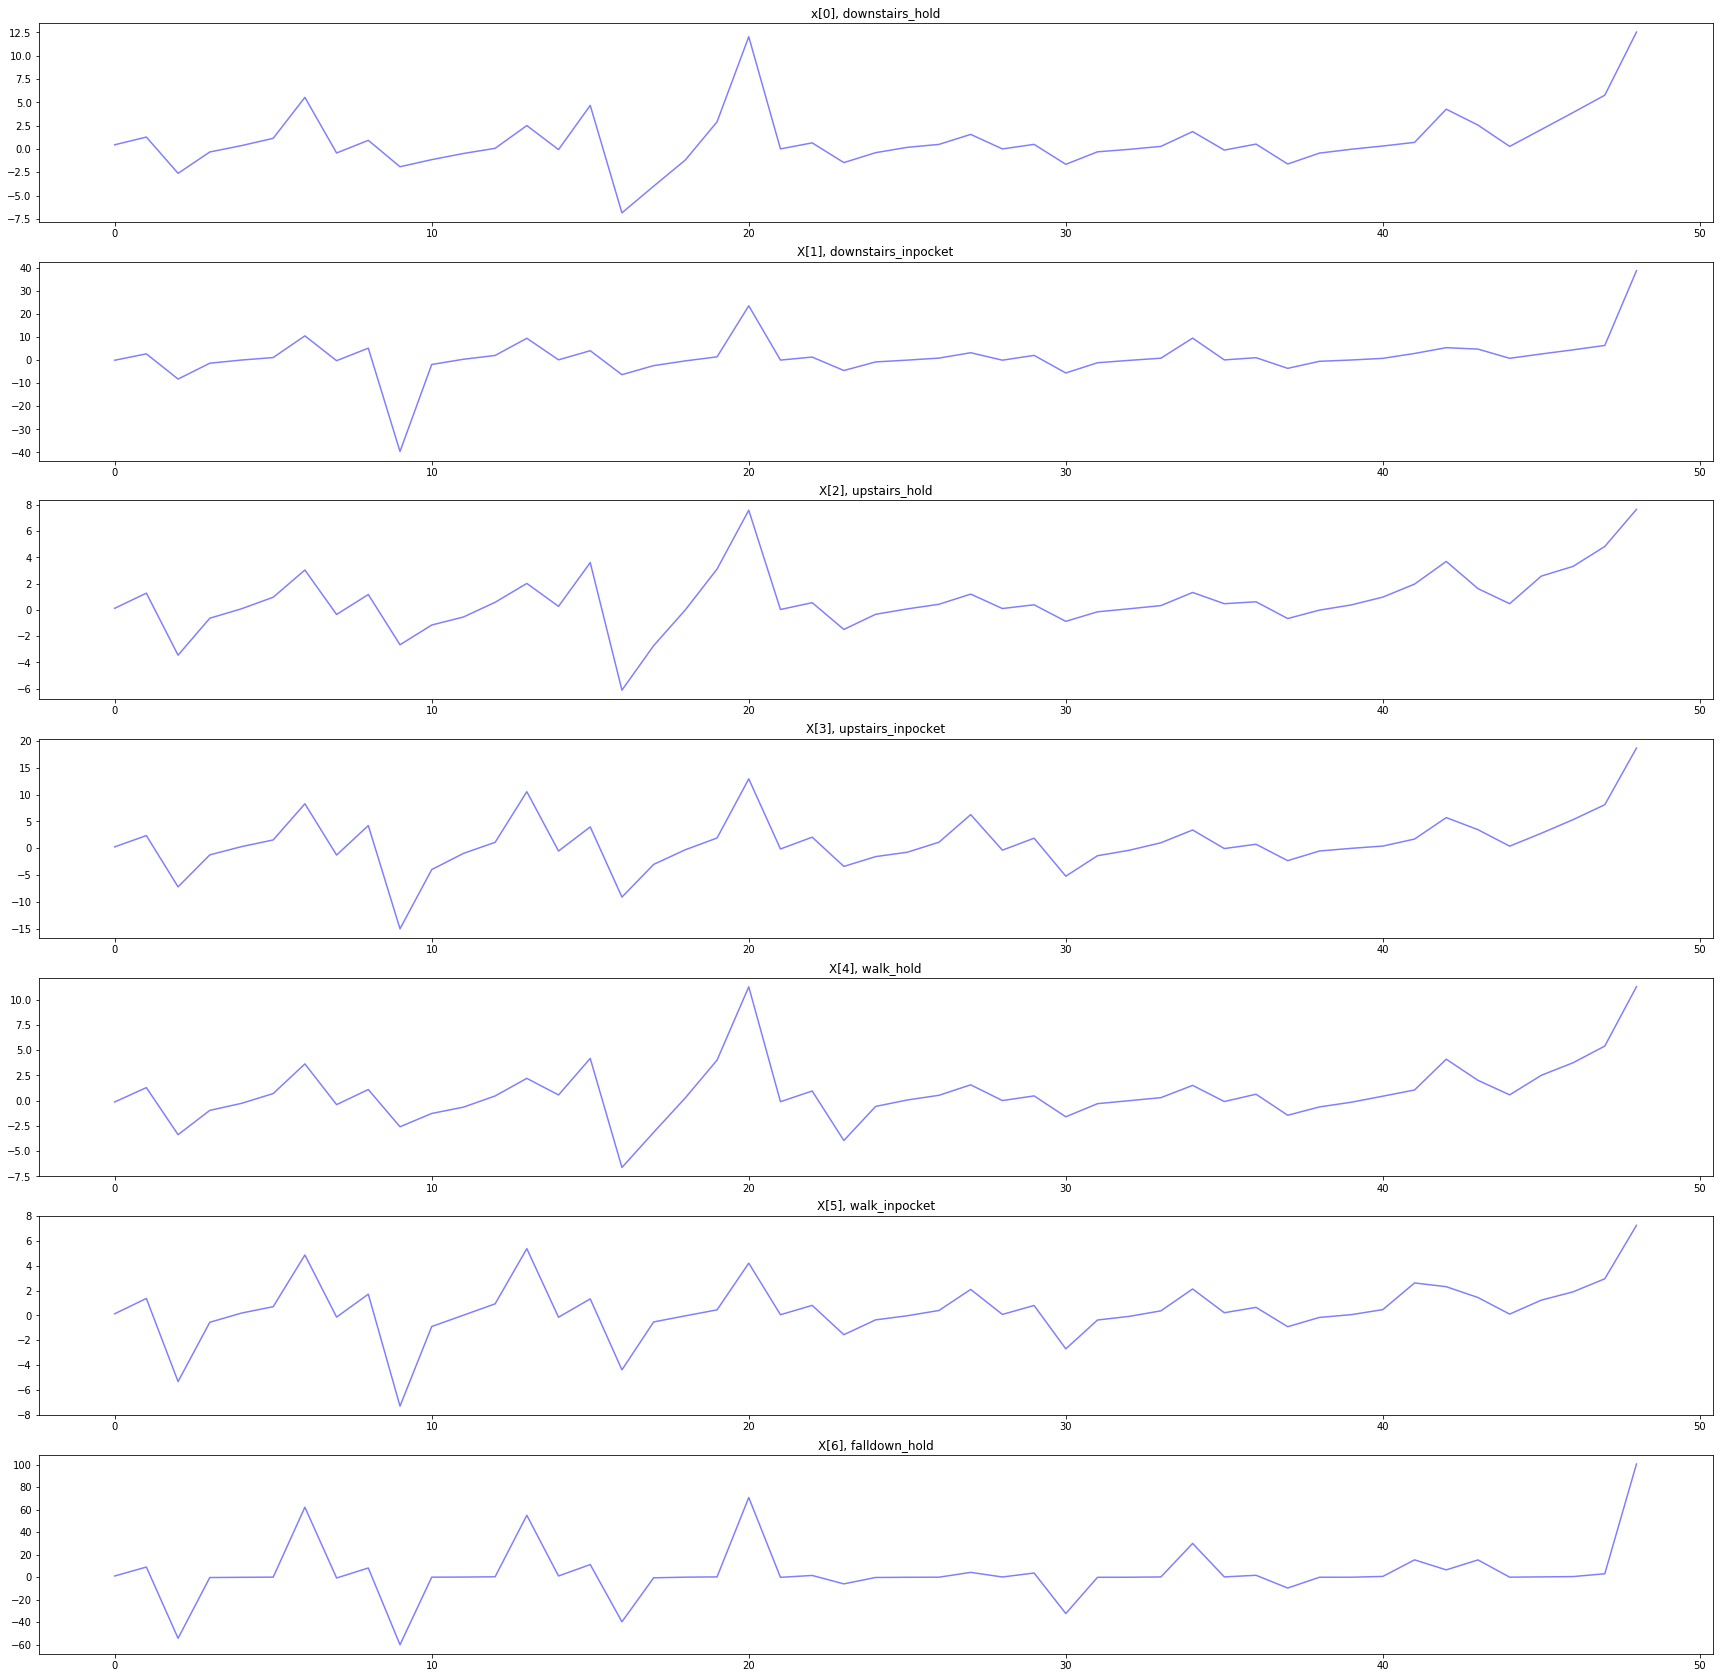

In [26]:
# plt.plot(x[:-8], y[0][:-8], 'b-' , alpha = 0.5)
"""plot each feature as subplot to clearly see each data's feature
down stairs hold range is -7.5~12.5"""
plt.figure(figsize = (30, 30))
plt.subplot(7 , 1 , 1)
plt.plot(x, y[0], 'b-' , alpha = 0.5)
plt.title('x[0], downstairs_hold')
plt.subplot(7 , 1 , 2)
plt.plot(x, y[1], 'b-' , alpha = 0.5)
plt.title('X[1], downstairs_inpocket')
plt.subplot(7 , 1 , 3)
plt.plot(x, y[2], 'b-' , alpha = 0.5)
plt.title('X[2], upstairs_hold')
plt.subplot(7 , 1 , 4)
plt.plot(x, y[3], 'b-' , alpha = 0.5)
plt.title('X[3], upstairs_inpocket')
plt.subplot(7 , 1 , 5)
plt.plot(x, y[4], 'b-' , alpha = 0.5)
plt.title('X[4], walk_hold')
plt.subplot(7 , 1 , 6)
plt.plot(x, y[5], 'b-' , alpha = 0.5)
plt.title('X[5], walk_inpocket')
plt.subplot(7 , 1 , 7)
plt.plot(x, y[6], 'b-' , alpha = 0.5)
plt.title('X[6], falldown_hold')

Text(0.5, 1.0, 'X[42], downstairs_hold7')

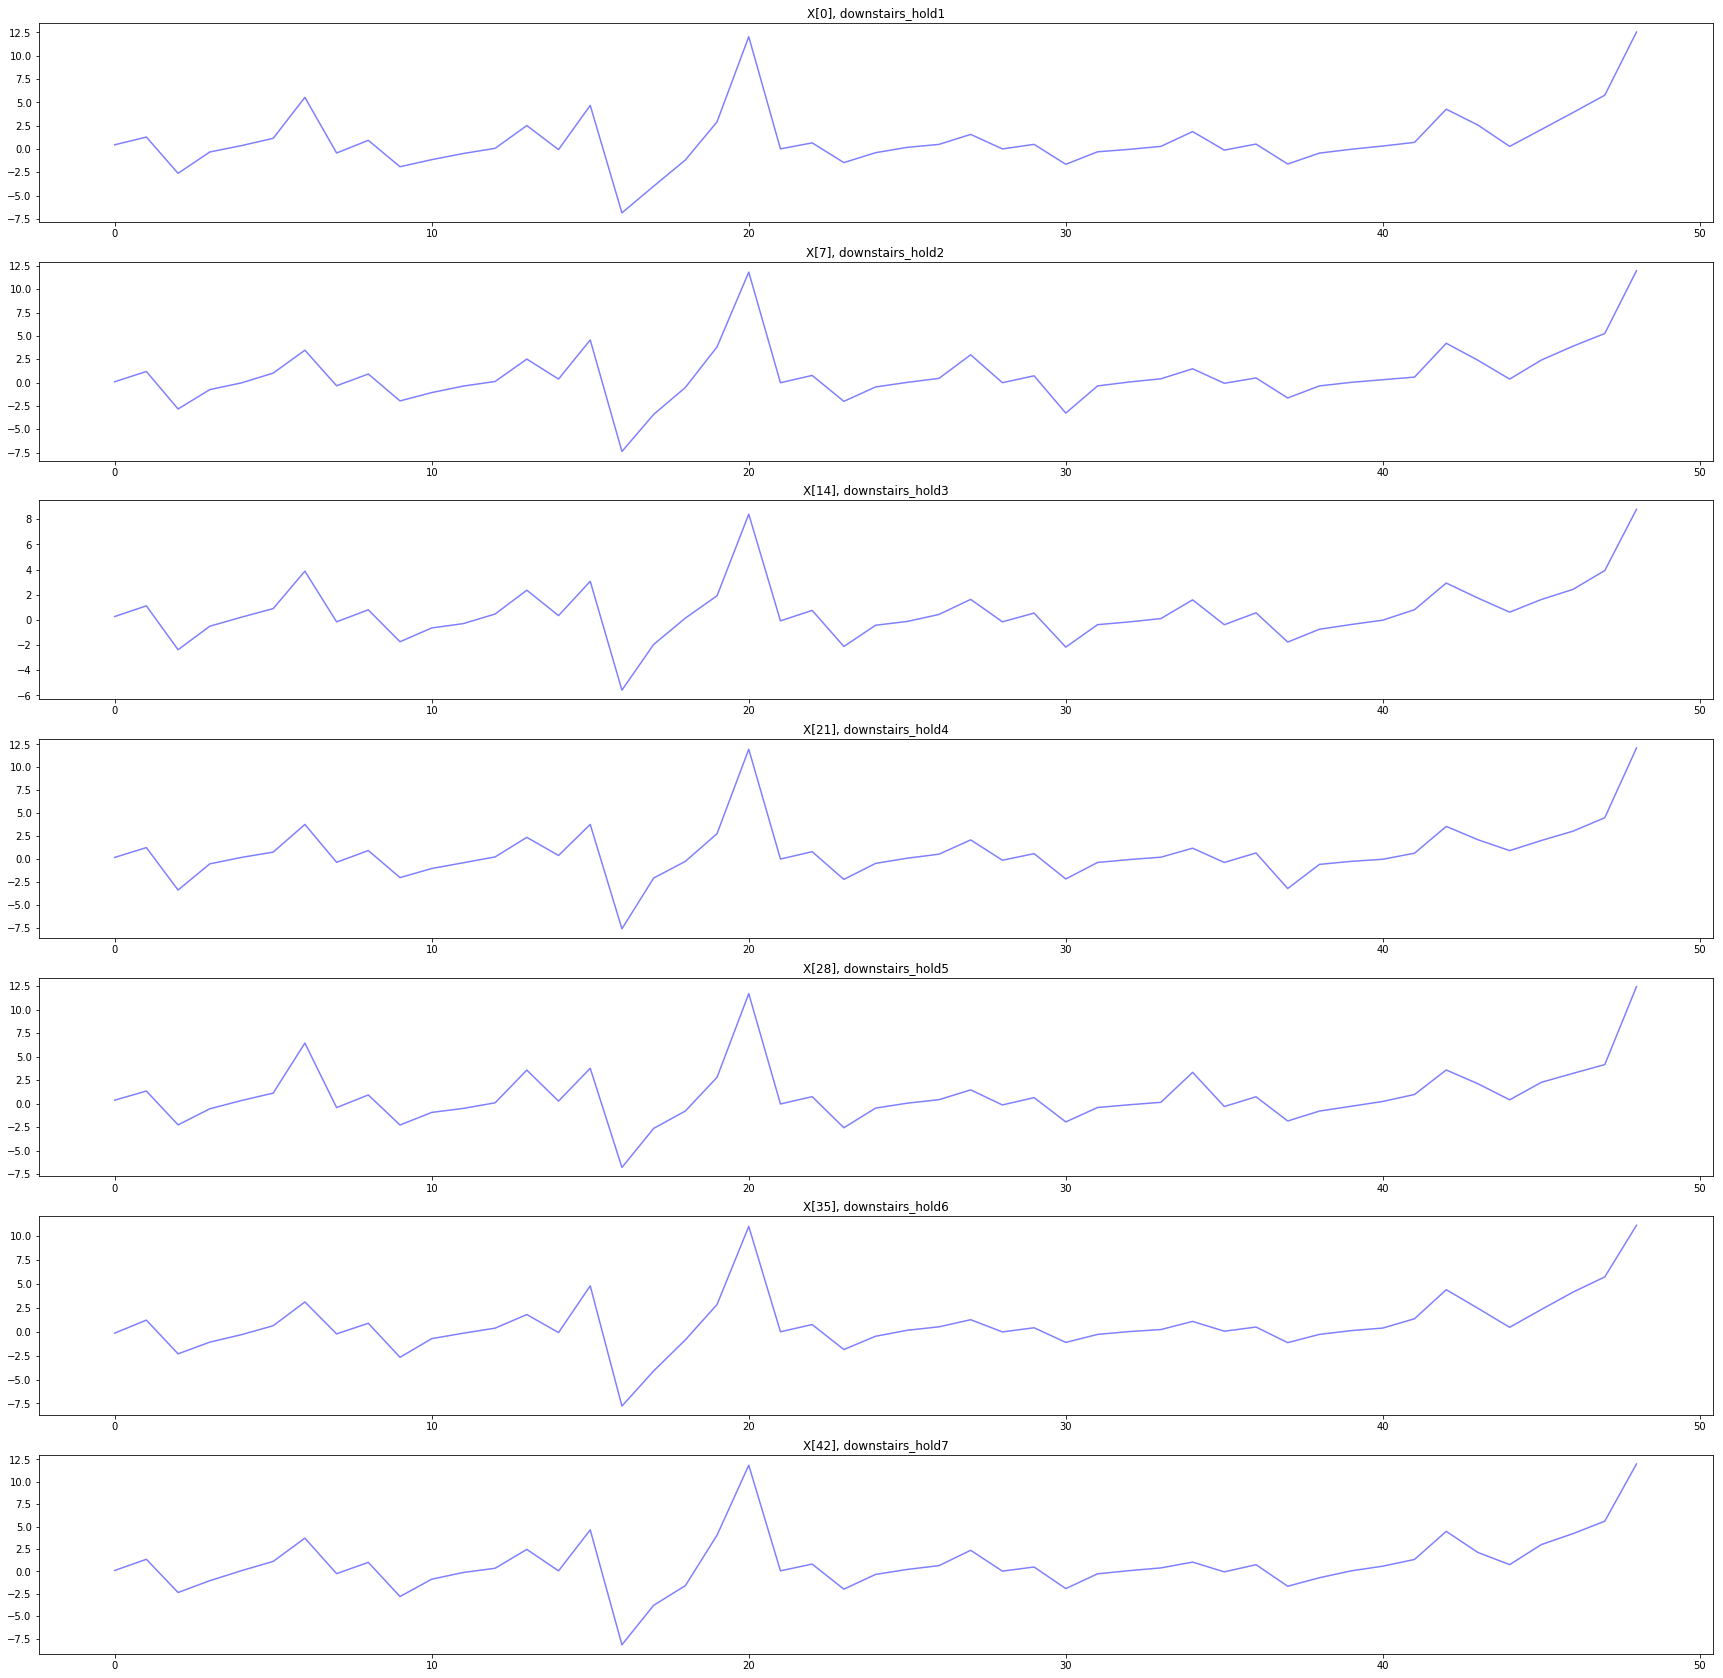

In [27]:
plt.figure(figsize = (30, 30))
plt.subplot(7 , 1 , 1)
plt.plot(x, y[0], 'b-' , alpha = 0.5)
plt.title('X[0], downstairs_hold1')
plt.subplot(7 , 1 , 2)
plt.plot(x, y[7], 'b-' , alpha = 0.5)
plt.title('X[7], downstairs_hold2')
plt.subplot(7 , 1 , 3)
plt.plot(x, y[14], 'b-' , alpha = 0.5)
plt.title('X[14], downstairs_hold3')
plt.subplot(7 , 1 , 4)
plt.plot(x, y[21], 'b-' , alpha = 0.5)
plt.title('X[21], downstairs_hold4')
plt.subplot(7 , 1 , 5)
plt.plot(x, y[28], 'b-' , alpha = 0.5)
plt.title('X[28], downstairs_hold5')
plt.subplot(7 , 1 , 6)
plt.plot(x, y[35], 'b-' , alpha = 0.5)
plt.title('X[35], downstairs_hold6')
plt.subplot(7 , 1 , 7)
plt.plot(x, y[42], 'b-' , alpha = 0.5)
plt.title('X[42], downstairs_hold7')

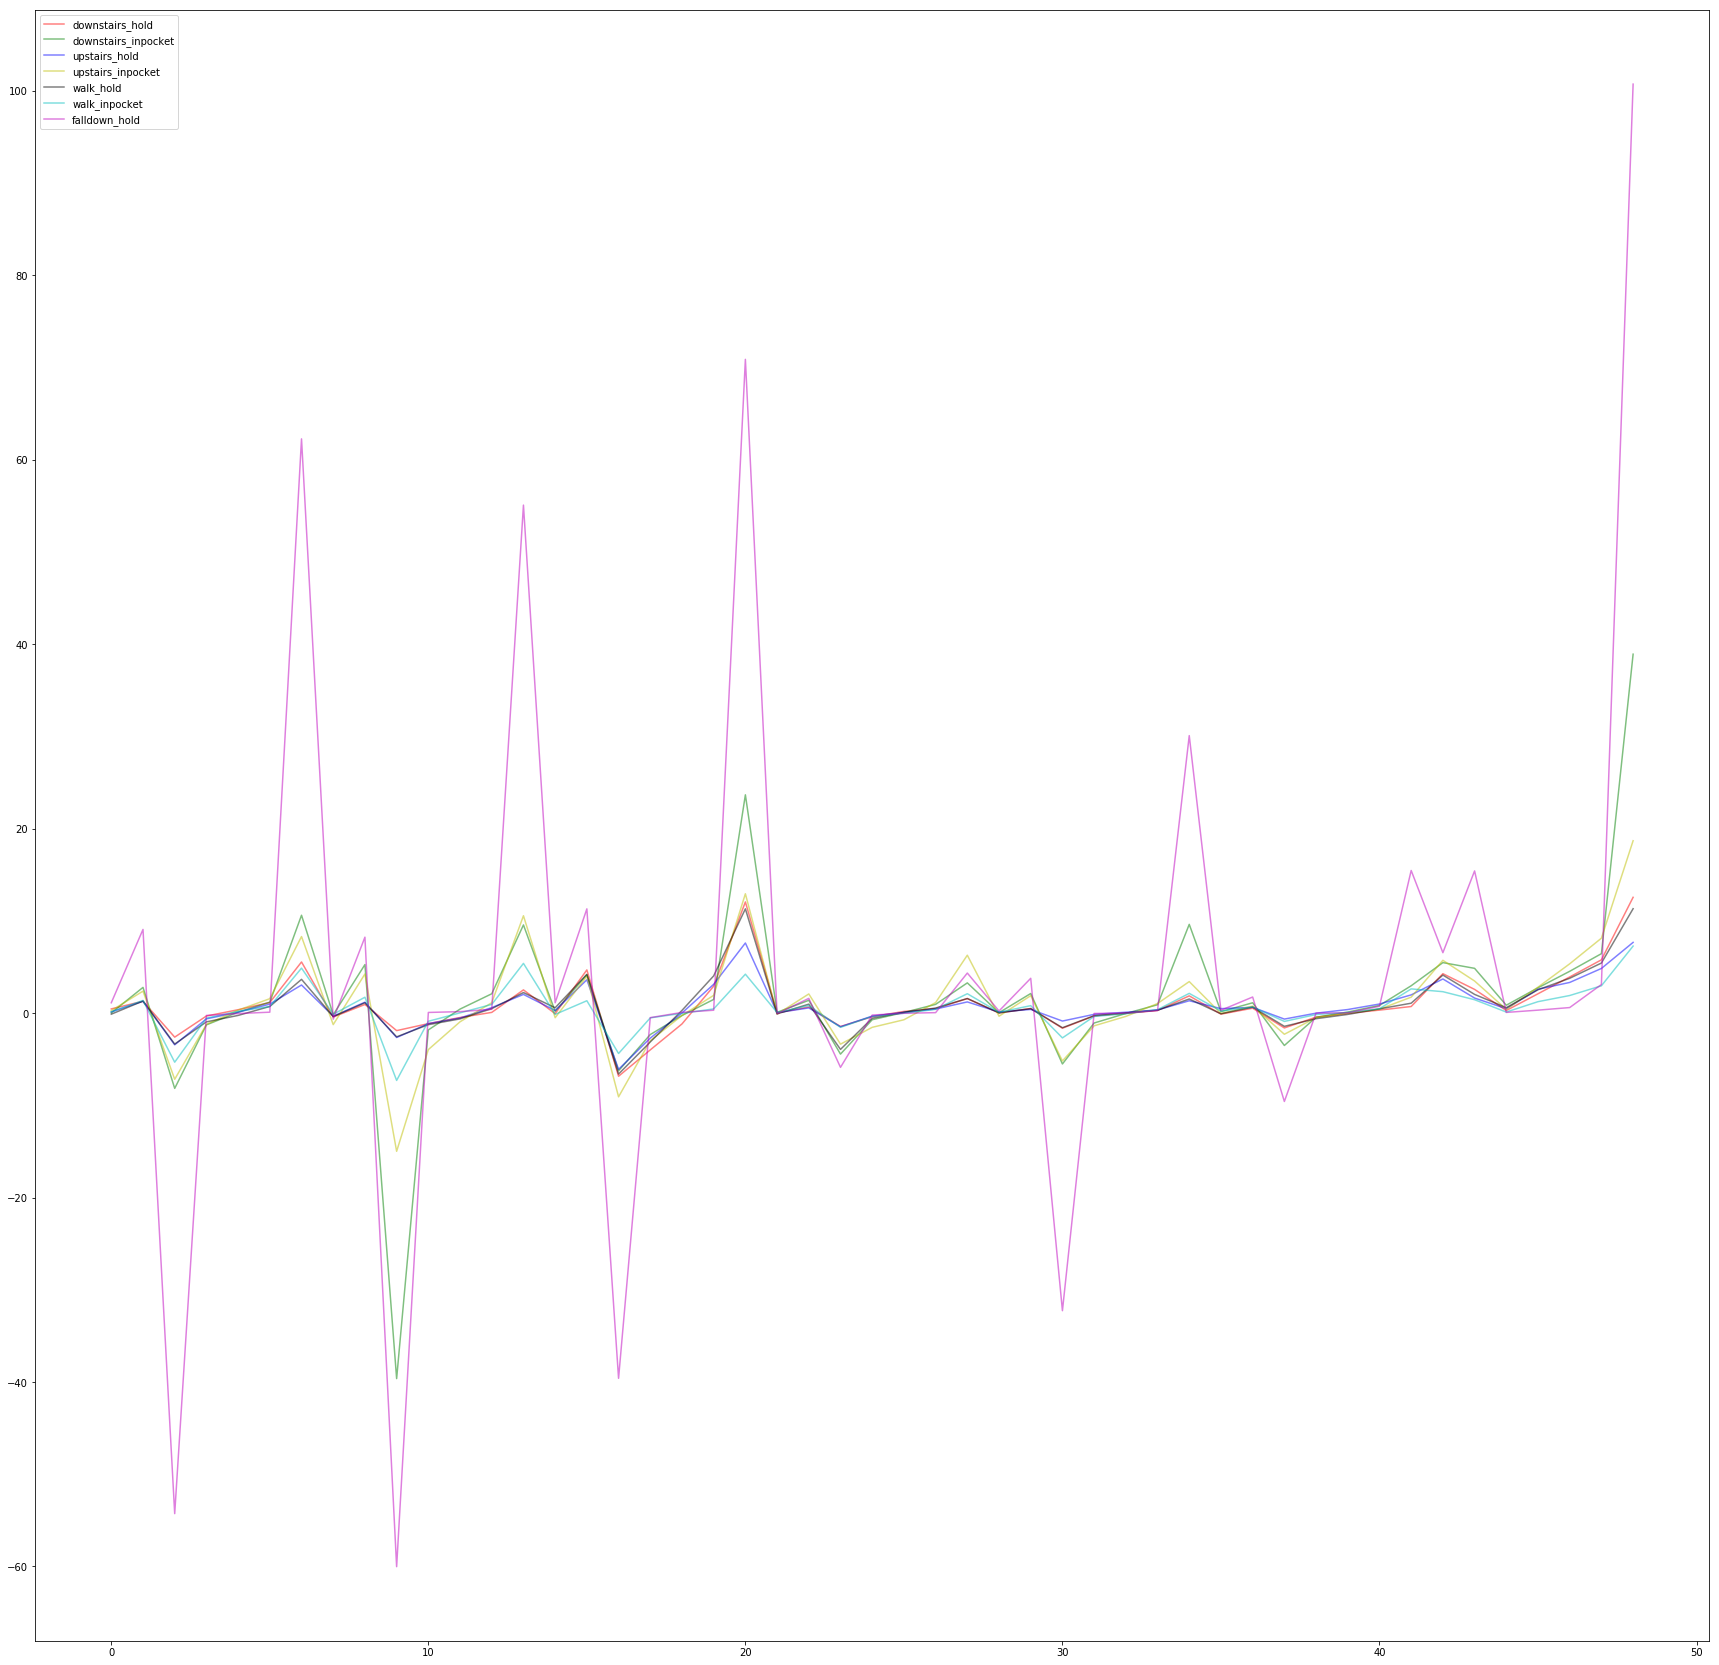

In [28]:
plt.figure(figsize = (30, 30))
plt.plot(x, y[0], 'r-' , alpha = 0.5, label='downstairs_hold') #red downstairs_hold
plt.plot(x, y[1], 'g-' , alpha = 0.5, label='downstairs_inpocket') #green downstairs_inpocket
plt.plot(x, y[2], 'b-' , alpha = 0.5, label='upstairs_hold') #blue upstairs_hold
plt.plot(x, y[3], 'y-' , alpha = 0.5, label='upstairs_inpocket') #yellow upstairs_inpocket
plt.plot(x, y[4], 'k-' , alpha = 0.5, label='walk_hold') #black walk_hold
plt.plot(x, y[5], 'c-' , alpha = 0.5, label='walk_inpocket') #cyan walk_inpocket
plt.plot(x, y[6], 'm-' , alpha = 0.5, label='falldown_hold') #magenta falldown_hold
plt.legend()

In [29]:
ML_tools()

ValueError: Found input variables with inconsistent numbers of samples: [105, 91]